In [24]:
# Load all packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

### Load the data

In [25]:
hotel = pd.read_csv('D:\Jupyter_Notebook\Hotel_Demand\data\hotel_featured.csv')

### Split data into training and testing subsets

In [26]:
X = hotel.drop(columns=['is_canceled'])
y = hotel['is_canceled']

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [28]:
# Use MinMaxScaler to scale data into range (0,1), not using StandardScale here because many columns should not contain negative values
from sklearn import preprocessing
import numpy as np

scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train=scaler.transform(X_train) 
X_train = pd.DataFrame(X_train,columns=X.columns)

X_test=scaler.transform(X_test)
X_test = pd.DataFrame(X_test,columns=X.columns)

### Modeling

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss

In [30]:
# Use GridSearchCV to tune the hyperparameter
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=1)
param = {'n_estimators':[10,30,50,100,150,200,300]}
gs = GridSearchCV(rf,param,cv=5,scoring='precision',n_jobs=-1)
gs_fit = gs.fit(X_train, y_train)

In [31]:
gs_fit.best_params_

{'n_estimators': 200}

In [32]:
gs_fit.best_score_

0.8753931643788974

In [33]:
print(accuracy_score(y_test, gs_fit.predict(X_test)))
print('precision_score: ', precision_score(y_test, gs_fit.predict(X_test)))

0.8835248720744904
precision_score:  0.8800805335346672


### Try PCA
reduce dimension with PCA and redo the random forest.

Text(0.5, 0, 'PCA feature')

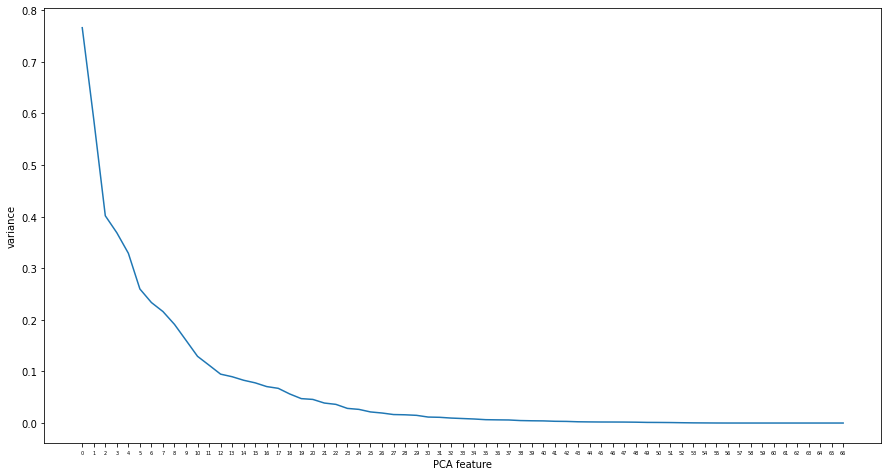

In [34]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

features = range(pca.n_components_)
fig= plt.figure(figsize=(15,8))
plt.plot(features,pca.explained_variance_)
plt.rc('xtick', labelsize=5)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')

# 12 components looks like a good choice.

In [35]:
pca = PCA(n_components = 12)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [36]:
# Use GridSearchCV to tune the hyperparameter
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=1)
param = {'n_estimators':[10,30,50,100,150,200,300]}
gs = GridSearchCV(rf,param,cv=5,scoring='precision',n_jobs=-1)
gs_fit = gs.fit(X_train_pca, y_train)

In [37]:
print('best_params_: ',gs_fit.best_params_)
print('best_score_: ',gs_fit.best_score_)
print('accuracy_score: ',accuracy_score(y_test, gs_fit.predict(X_test_pca)))
print('precision_score: ', precision_score(y_test, gs_fit.predict(X_test_pca)))

best_params_:  {'n_estimators': 100}
best_score_:  0.8321445422109643
accuracy_score:  0.860120795235299
precision_score:  0.8360917003800417


### Random Forest Final Model and Analysis
From the previous analysis, the model with pca with n_estimators=200 performs the best. Again, precision should be the metric to focus on. This model has the precision score of 0.88. Amount all the positive prediction, 88% of them are correct.

In [39]:
rf = RandomForestClassifier(n_estimators=200,random_state=1)
model_res = rf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

In [40]:
print('accuracy_score: ',accuracy_score(y_test, y_pred))
print('precision_score: ', precision_score(y_test, y_pred))

accuracy_score:  0.8835248720744904
precision_score:  0.8800805335346672


In [45]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     15024
           1       0.88      0.79      0.83      8818

    accuracy                           0.88     23842
   macro avg       0.88      0.86      0.87     23842
weighted avg       0.88      0.88      0.88     23842



### Create Confusion Matrix Plots

The confusion matrix tells us that about 79% of cancellations are correctly identified.

Confusion matrix, without normalization
[[14071   953]
 [ 1824  6994]]
Normalized confusion matrix
[[0.94 0.06]
 [0.21 0.79]]


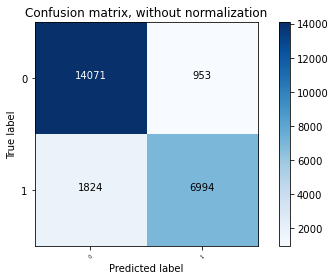

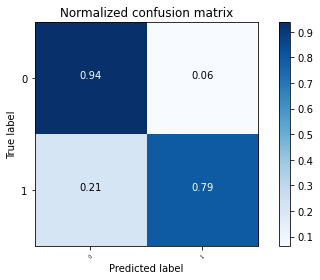

In [41]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### ROC Curve and AUC

Area under ROC curve = 0.86


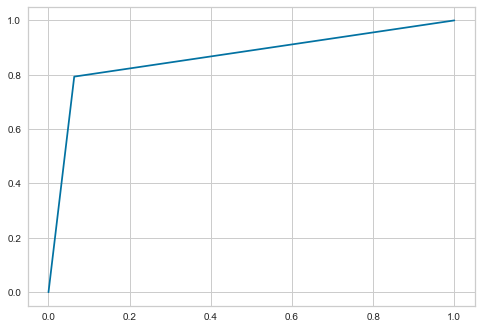

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
y_pred_df = model_res.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred)
plt.plot(fpr_gb, tpr_gb, label='GBT')
roc_auc_gb = auc(fpr_gb, tpr_gb)
print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

D:\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


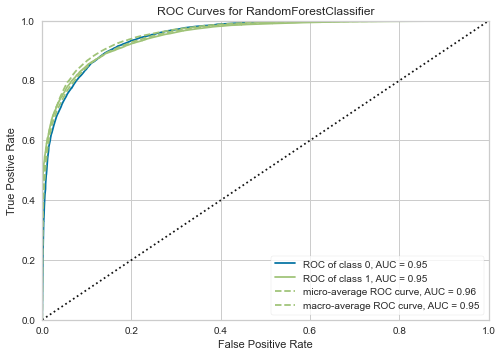

In [52]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(model_res, classes=["0", "1"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();                       # Finalize and show the figure

### Plot feature importances

30


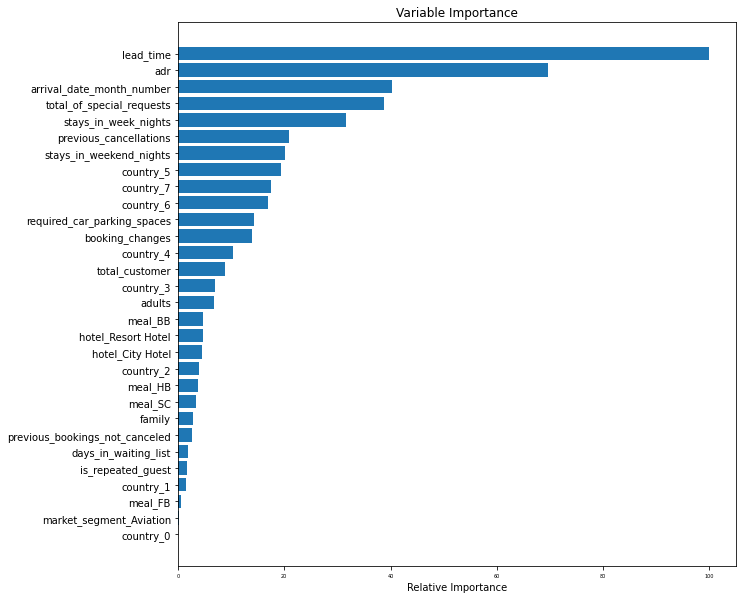

In [42]:
feature_importance = model_res.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Conclusion

In this model analysis, the Random Forest model without pca with n_estimator=200 gives the best result. 79% of cancellations are correctly identified and 88% of the positive prediction is correct. In this model, the lead_time has the biggest effect on the cancellation. This seems reasonable that, as the number of days that elapsed between the entering date of the booking into the PMS and the arrival date gets longer, the customers are more likely to cancel the order. The second important feature is the average daily rate. As the adr foes higher, customers are more likely to cancel the order. The hotel owner could like into it and figure out why this is happening. We definitely do not want customers to cancel high pricing rooms. 

Although this model has a pretty good performance on the True Positive rate (it correctly identifies 79% of the cancellation), the precision rate is still not high enough compared to the Gradient Boosting model. Since precision is the key metric that we should focus on this problem, Random Forest is still not the best model to choose from.